In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

sns.set_palette("deep")

In [24]:
data_booking = pd.read_csv('scraped_data/booking_results.csv')
data_expedia = pd.read_csv('scraped_data/expedia_results.csv')

In [25]:
data_booking.isnull().sum()

TTT                        0
LOS                        0
Date of Search             0
Index                      0
Hotel Name                 0
Score                      0
Distance                   0
Price Before Tax           0
Taxes                      0
Total Price                0
Nights & Adults            0
Stars                      0
Subway Access              0
Neighborhood               0
Room Type                  0
Bed Type                 100
Cancellation Policy     4226
Payment Policy         11942
Review Class               0
Number of Reviews          0
dtype: int64

In [26]:
# Preprocessing the data
data_booking = data_booking.copy().drop(columns=['Subway Access', 'Nights & Adults', 'Payment Policy']) # Drop of the columns that are not useful
data_booking = data_booking.copy().dropna(subset=['Bed Type', 'Cancellation Policy']) # Drop of the rows with missing values
data_expedia = data_expedia.copy().dropna(subset=['Classification'])

data_booking = data_booking[data_booking['Review Class'] != 'Review score'] # Drop of the rows with the wrong values

columns_renamed_booking = [i.replace(' ', '_').lower() for i in data_booking.columns] # Renaming the columns to have a more readable name
columns_renamed_expedia = [i.replace(' ', '_').lower() for i in data_expedia.columns]
data_booking.columns = columns_renamed_booking
data_expedia.columns = columns_renamed_expedia

# Renaming columns in both dataframes to have the same names for similar data
data_booking.rename(columns={
    'total_price': 'price_after_tax',
    'score': 'rating',
    'number_of_reviews': 'reviews'
}, inplace=True)

data_expedia.rename(columns={
    'classification': 'review_class'
}, inplace=True)


data_booking['date_of_search'] = pd.to_datetime(data_booking['date_of_search'])
data_expedia['date_of_search'] = pd.to_datetime(data_expedia['date_of_search'])

# Convert 'price_before_tax' in expedia from object to float64 (or int64 if applicable)
data_expedia['price_before_tax'] = data_expedia['price_before_tax'].copy().replace(',', '', regex=True)
data_expedia['price_before_tax'] = pd.to_numeric(data_expedia['price_before_tax'], errors='coerce')

In [27]:
data_booking.head(2)

,ttt,los,date_of_search,index,hotel_name,rating,distance,price_before_tax,taxes,price_after_tax,stars,neighborhood,room_type,bed_type,cancellation_policy,review_class,reviews
2,1,1,2024-07-20,2,Four Points by Sheraton New York Downtown,7.4,7.0,119,21,140.0,3,Manhattan,"Guest room, 1 Queen",1 queen bed,Free cancellation,Good,2259
4,1,1,2024-07-20,4,Courtyard by Marriott Times Square West,8.2,1.8,151,26,177.0,3,Hell's Kitchen,King Room,1 king bed,Free cancellation,Very Good,2898


In [28]:
data_expedia.head(2)

,ttt,los,date_of_search,index,hotel_name,price_before_tax,price_after_tax,rating,review_class,reviews,neighborhood
0,1,1,2024-07-20,0,Millennium Hilton New York One UN Plaza,256,337,8.2,Very Good,1382,New York
1,1,1,2024-07-20,1,Moxy NYC Chelsea,290,370,8.6,Excellent,1020,Chelsea


## Part B - data exploration

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

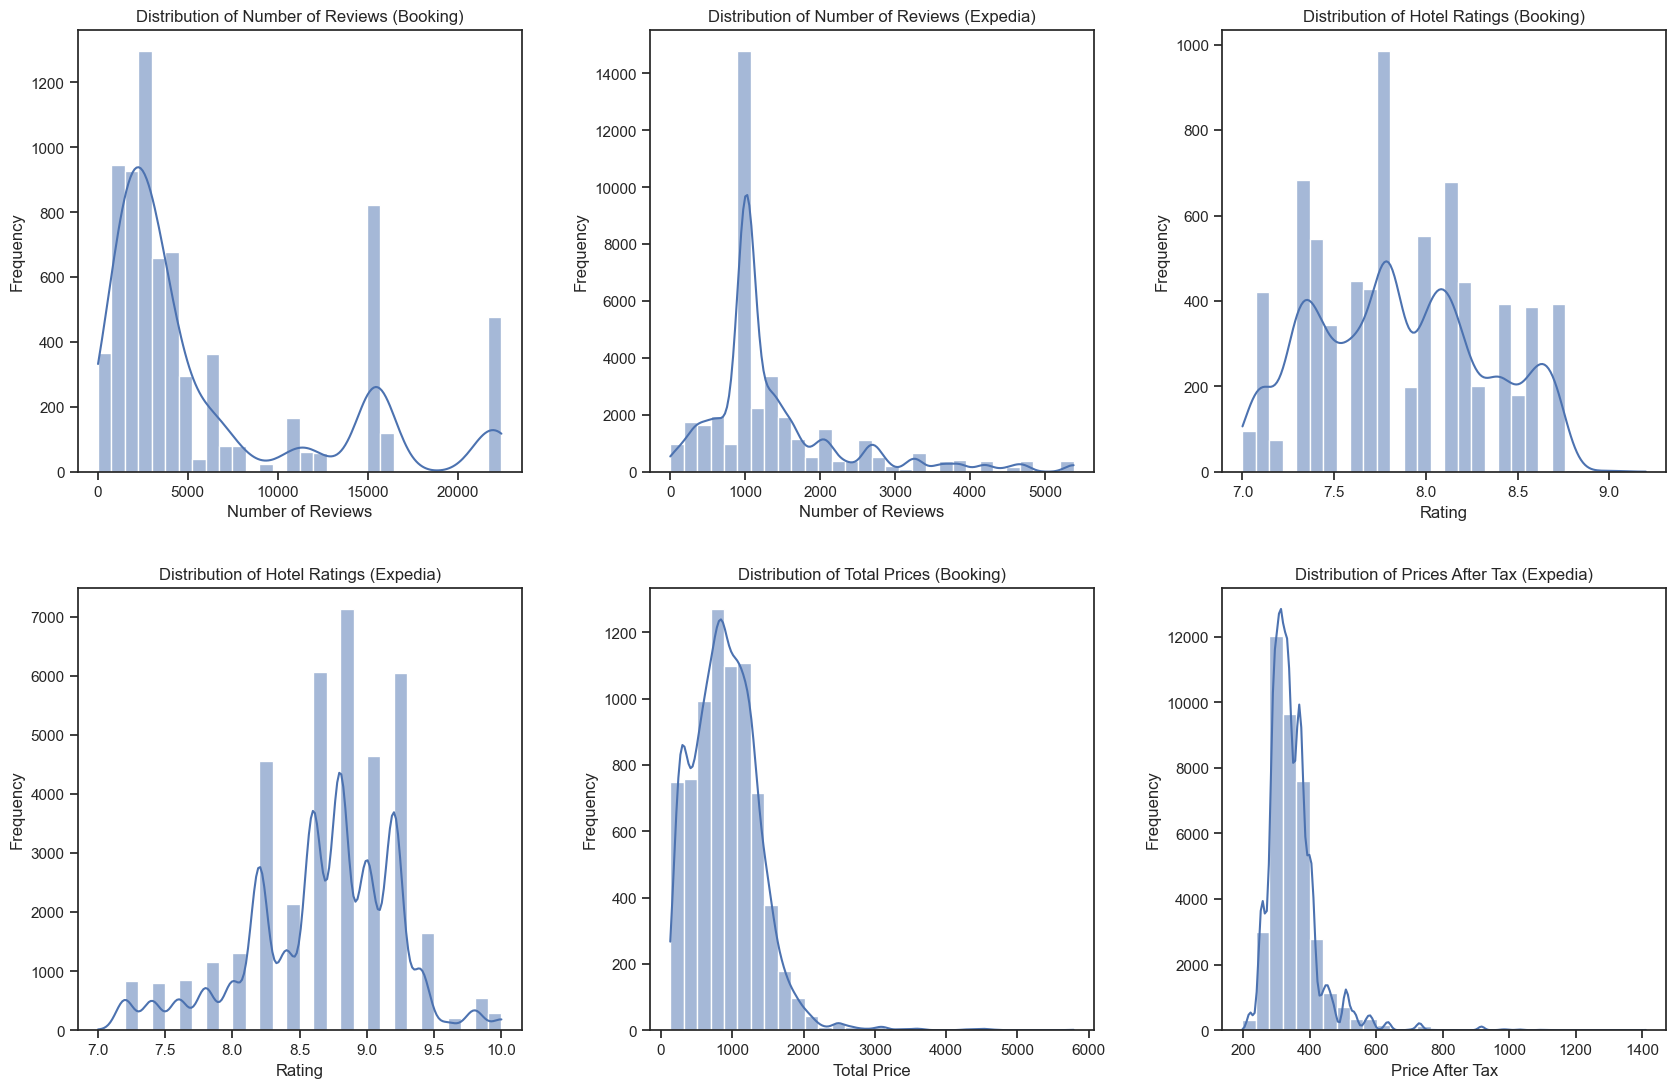

In [29]:
# Set up the figure size and grid layout
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.tight_layout(pad=5.0)

# Distribution of Number of Reviews
sns.histplot(data_booking['reviews'], kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Number of Reviews (Booking)')
axes[0, 0].set_xlabel('Number of Reviews')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(data_expedia['reviews'], kde=True, bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Number of Reviews (Expedia)')
axes[0, 1].set_xlabel('Number of Reviews')
axes[0, 1].set_ylabel('Frequency')

# Distribution of Hotel Ratings
sns.histplot(data_booking['rating'], kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Hotel Ratings (Booking)')
axes[0, 2].set_xlabel('Rating')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(data_expedia['rating'], kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Hotel Ratings (Expedia)')
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Frequency')

# Distribution of Prices
sns.histplot(data_booking['price_after_tax'], kde=True, bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Total Prices (Booking)')
axes[1, 1].set_xlabel('Total Price')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(data_expedia['price_after_tax'], kde=True, bins=30, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Prices After Tax (Expedia)')
axes[1, 2].set_xlabel('Price After Tax')
axes[1, 2].set_ylabel('Frequency')

plt.show()

# Outlier Removal using Tukey's 1.5 IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data_booking = remove_outliers(data_booking, 'price_after_tax')
data_expedia = remove_outliers(data_expedia, 'price_after_tax')

# Ordinal Encoding
ordinal_mapping_booking = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4
}

ordinal_mapping_expedia = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4,
    'Exceptional': 5
}

data_booking['review_class'] = data_booking['review_class'].map(ordinal_mapping_booking)
data_expedia['review_class'] = data_expedia['review_class'].map(ordinal_mapping_expedia)

def encode_features(data_booking, data_expedia):
    # One-Hot Encoding for Booking
    one_hot_booking = pd.get_dummies(data_booking[['cancellation_policy', 'neighborhood', 'bed_type', 'room_type']], 
                                     prefix=['cancel_policy', 'neighborhood', 'bed_type', 'room_type'])
    data_booking = pd.concat([data_booking, one_hot_booking], axis=1)
    # Drop original columns after encoding
    data_booking.drop(['cancellation_policy', 'neighborhood', 'bed_type', 'room_type'], axis=1, inplace=True)

    # One-Hot Encoding for Expedia
    one_hot_expedia = pd.get_dummies(data_expedia[['neighborhood']], prefix=['neighborhood'])
    data_expedia = pd.concat([data_expedia, one_hot_expedia], axis=1)
    # Drop original column after encoding
    data_expedia.drop(['neighborhood'], axis=1, inplace=True)

    # Label Encoding for hotel_name in both Booking and Expedia
    label_encoder_booking = LabelEncoder()
    data_booking['hotel_name_encoded'] = label_encoder_booking.fit_transform(data_booking['hotel_name'])
    data_booking.drop(['hotel_name'], axis=1, inplace=True)

    label_encoder_expedia = LabelEncoder()
    data_expedia['hotel_name_encoded'] = label_encoder_expedia.fit_transform(data_expedia['hotel_name'])
    data_expedia.drop(['hotel_name'], axis=1, inplace=True)

    # Encoding date_of_search into day, month, and year for both datasets
    for dataset in [data_booking, data_expedia]:
        dataset['search_day'] = dataset['date_of_search'].dt.day
        dataset['search_month'] = dataset['date_of_search'].dt.month
        dataset['search_year'] = dataset['date_of_search'].dt.year
        dataset.drop(['date_of_search'], axis=1, inplace=True)

    return data_booking, data_expedia

data_booking_processed, data_expedia_processed = encode_features(data_booking, data_expedia)

# # PairGrid Analysis
# sns.pairplot(data_booking[['price_after_tax', 'rating', 'stars', 'reviews']])
# plt.suptitle('PairGrid of Booking Data')
# plt.show()

# sns.pairplot(data_expedia[['price_after_tax', 'rating', 'reviews']])
# plt.suptitle('PairGrid of Expedia Data')
# plt.show()

## Part C -  prediction of rooms prices 

In [30]:
# Selecting only 100 rows from both dataframes to train the models
data_booking_processed = data_booking_processed.sample(n=50, random_state=42)
data_expedia_processed = data_expedia_processed.sample(n=50, random_state=42)

Booking Data:


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn

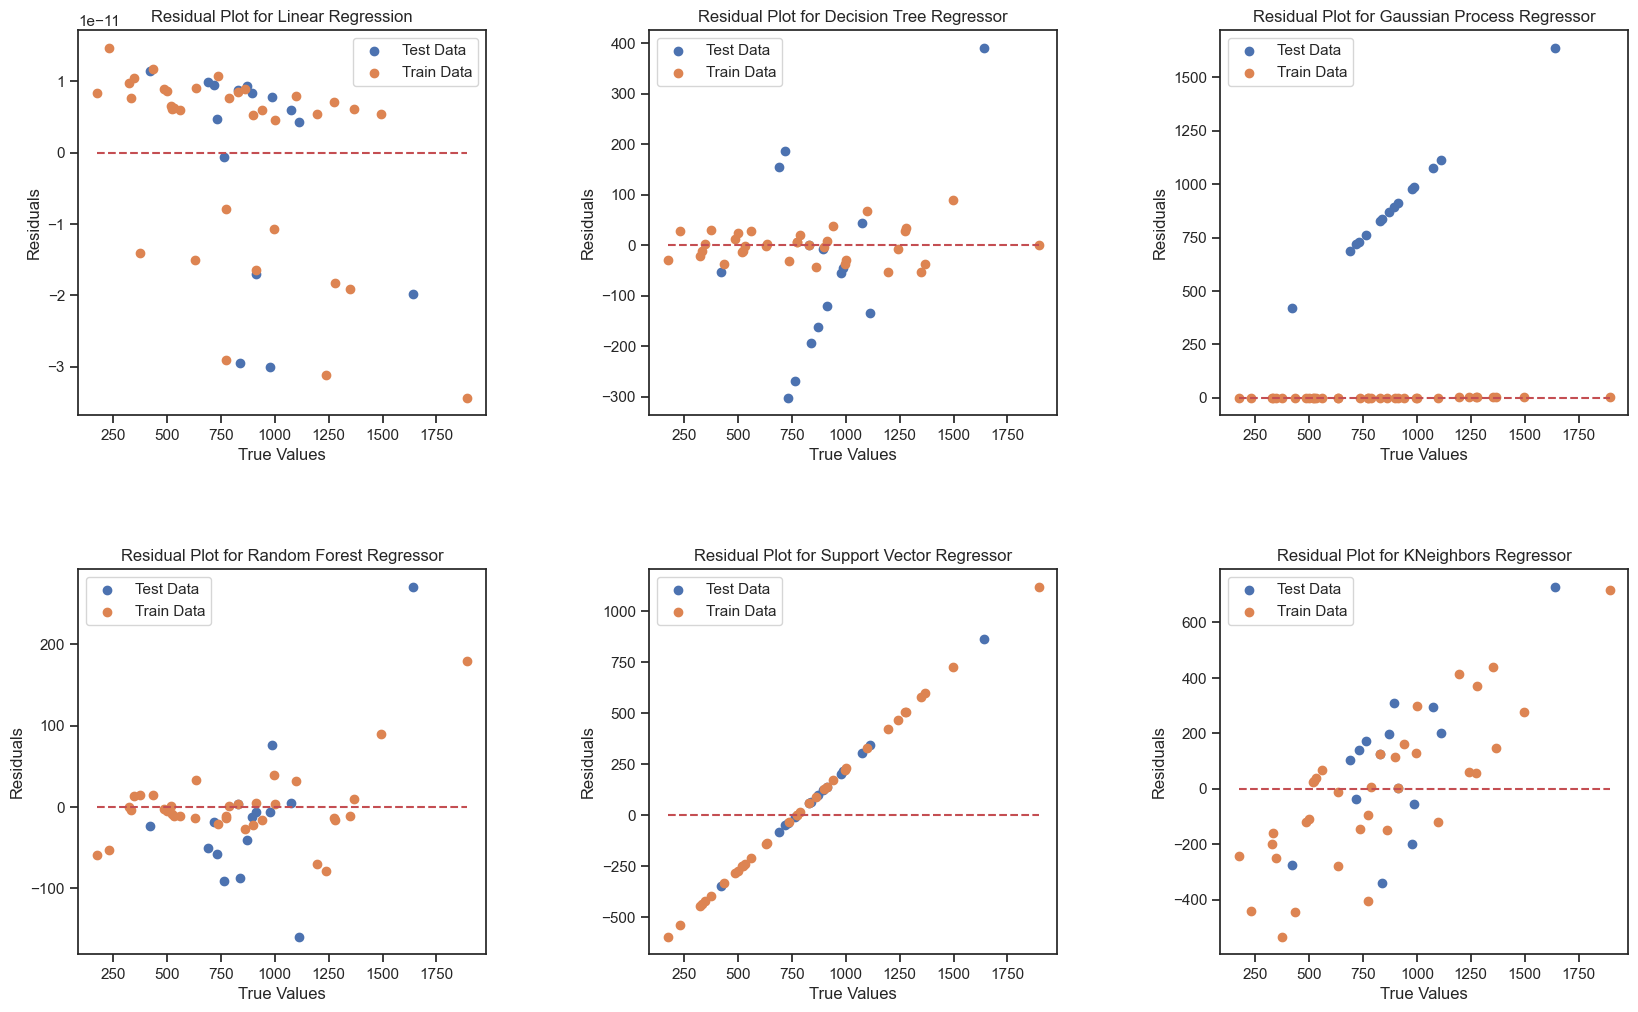

                        Model     MSE Train      MSE Test    RMSE Train  \
0           Linear Regression  1.787396e-22  2.092554e-22  1.336935e-11   
1     Decision Tree Regressor  1.004538e+03  3.211213e+04  3.169445e+01   
2  Gaussian Process Regressor  8.110202e-01  8.722465e+05  9.005666e-01   
3     Random Forest Regressor  1.861652e+03  8.575340e+03  4.314687e+01   
4    Support Vector Regressor  1.589862e+05  8.215138e+04  3.987307e+02   
5        KNeighbors Regressor  7.104539e+04  7.377032e+04  2.665434e+02   

      RMSE Test     MAE Train      MAE Test  R2 Train    R2 Test  
0  1.446566e-11  1.124688e-11  1.178933e-11  1.000000   1.000000  
1  1.791986e+02  2.421429e+01  1.412667e+02  0.993645   0.518417  
2  9.339414e+02  8.082489e-01  8.975333e+02  0.999995 -12.081006  
3  9.260313e+01  2.598514e+01  6.032200e+01  0.988223   0.871396  
4  2.866206e+02  3.224724e+02  1.965348e+02 -0.005798  -0.232017  
5  2.716069e+02  2.051200e+02  2.124267e+02  0.550544  -0.106327  

Expe

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn

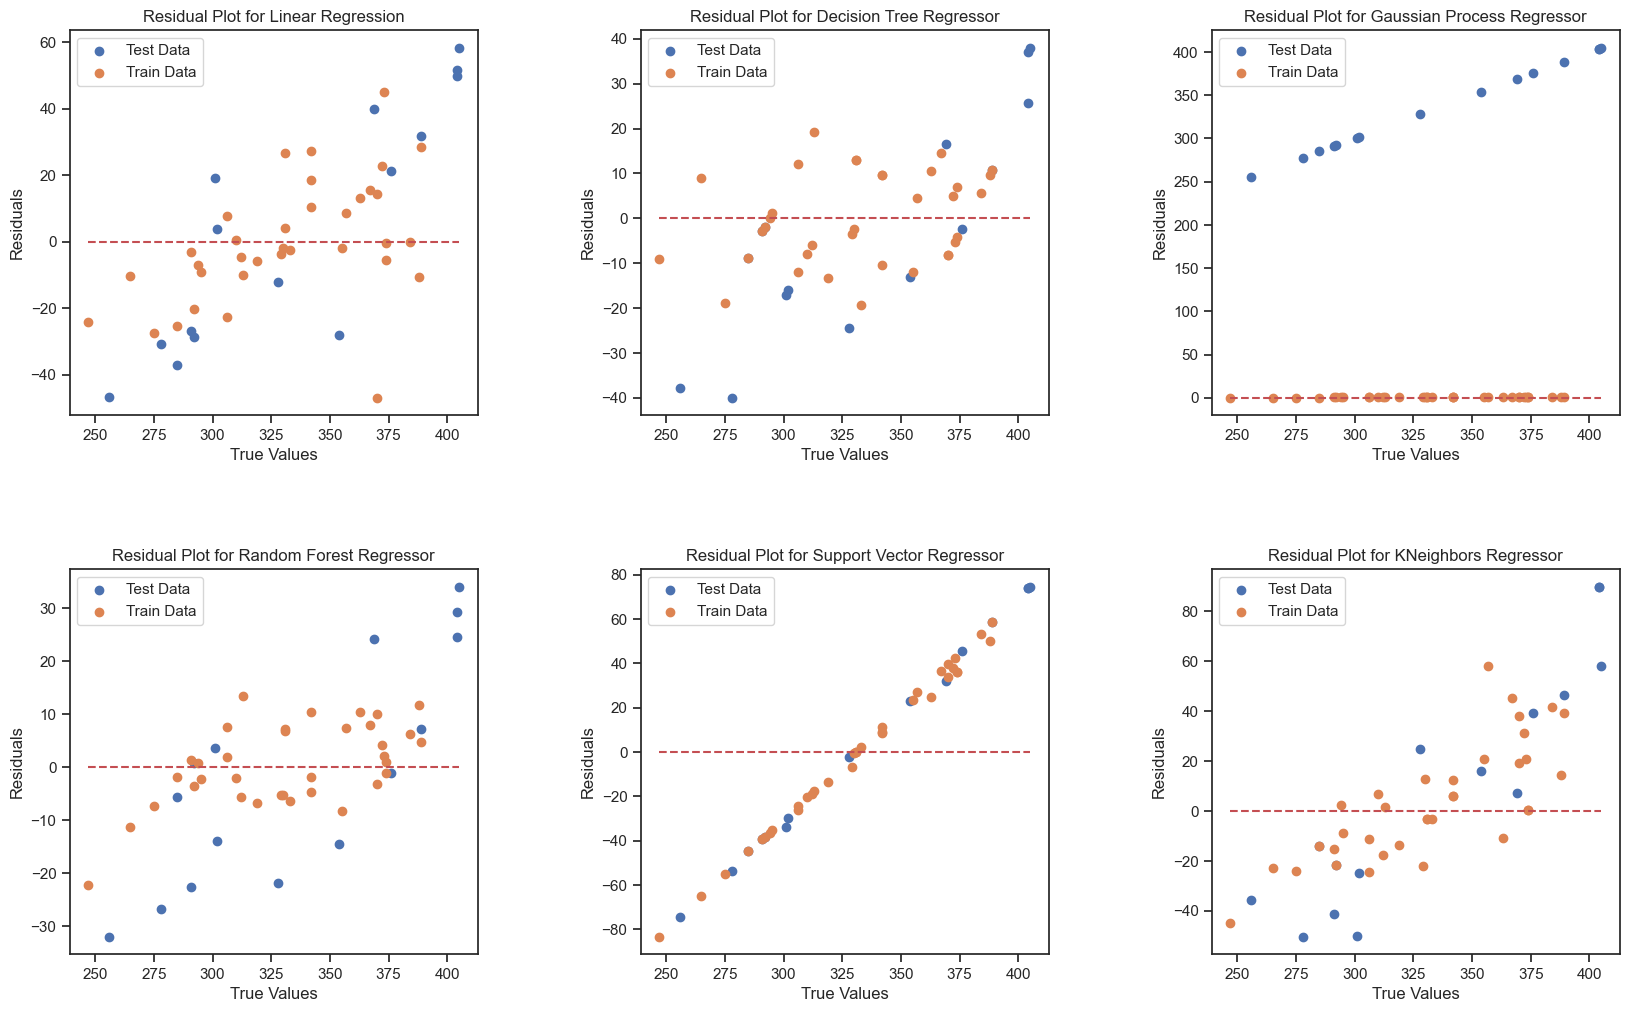

                        Model    MSE Train       MSE Test  RMSE Train  \
0           Linear Regression   335.233623    1263.825162   18.309386   
1     Decision Tree Regressor   101.734388     553.615160   10.086347   
2  Gaussian Process Regressor     0.111500  115200.666667    0.333916   
3     Random Forest Regressor    56.783354     428.976773    7.535473   
4    Support Vector Regressor  1292.688545    2607.869209   35.953978   
5        KNeighbors Regressor   541.945143    2228.938667   23.279715   

    RMSE Test  MAE Train    MAE Test  R2 Train    R2 Test  
0   35.550319  13.910466   32.397480  0.757944   0.508871  
1   23.529028   8.836735   19.480952  0.926542   0.784862  
2  339.412237   0.331840  335.600000  0.999919 -43.767562  
3   20.711754   6.139429   17.464000  0.958999   0.833297  
4   51.067301  30.201928   46.565555  0.066612  -0.013431  
5   47.211637  18.217143   40.613333  0.608687   0.133823  


In [31]:
# # Feature Engineering
# def add_features(data):
#     data['day_of_week'] = pd.to_datetime(data['date_of_search']).dt.dayofweek
#     data['end_of_month'] = pd.to_datetime(data['date_of_search']).dt.daysinmonth - pd.to_datetime(data['date_of_search']).dt.day
#     return data

# data_booking_processed = add_features(data_booking_processed)
# data_expedia_processed = add_features(data_expedia_processed)

# Function to train and evaluate models
def train_and_evaluate_models(data, target_column):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Models to be trained
    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree Regressor": DecisionTreeRegressor(),
        "Gaussian Process Regressor": GaussianProcessRegressor(kernel=C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))),
        "Random Forest Regressor": RandomForestRegressor(),
        "Support Vector Regressor": SVR(),
        "KNeighbors Regressor": KNeighborsRegressor()
    }
    
    # Setup for 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots
    
    # Counter for subplot index
    plot_row, plot_col = 0, 0
    
    # Training and evaluating models
    results = []
    for model_name, model in models.items():
        # Hyperparameter tuning for specific models
        if model_name == "Decision Tree Regressor":
            param_grid_dt = {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]}
            model = GridSearchCV(model, param_grid_dt, cv=3)
        elif model_name == "Gaussian Process Regressor":
            param_grid_gp = {'alpha': [1e-2, 1e-3, 1e-4]}
            model = GridSearchCV(model, param_grid_gp, cv=3)
            
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate error metrics
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        
        results.append({
            "Model": model_name,
            "MSE Train": mse_train,
            "MSE Test": mse_test,
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test,
            "MAE Train": mae_train,
            "MAE Test": mae_test,
            "R2 Train": r2_train,
            "R2 Test": r2_test
        })
        
        # Plot residuals in the grid
        ax = axs[plot_row, plot_col]
        ax.scatter(y_test, y_test - y_pred_test, label="Test Data")
        ax.scatter(y_train, y_train - y_pred_train, label="Train Data")
        ax.hlines(y=0, xmin=min(y), xmax=max(y), colors='r', linestyles='dashed')
        ax.set_xlabel("True Values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot for {model_name}")
        ax.legend()
        
        # Update subplot index
        plot_col += 1
        if plot_col > 2:
            plot_col = 0
            plot_row += 1
    
    plt.show()
    
    # Display results
    results_df = pd.DataFrame(results)
    return results_df

# Apply the function to both datasets
print("Booking Data:")
results_booking = train_and_evaluate_models(data_booking_processed, 'price_after_tax')
print(results_booking)

print("\nExpedia Data:")
results_expedia = train_and_evaluate_models(data_expedia_processed, 'price_after_tax')
print(results_expedia)

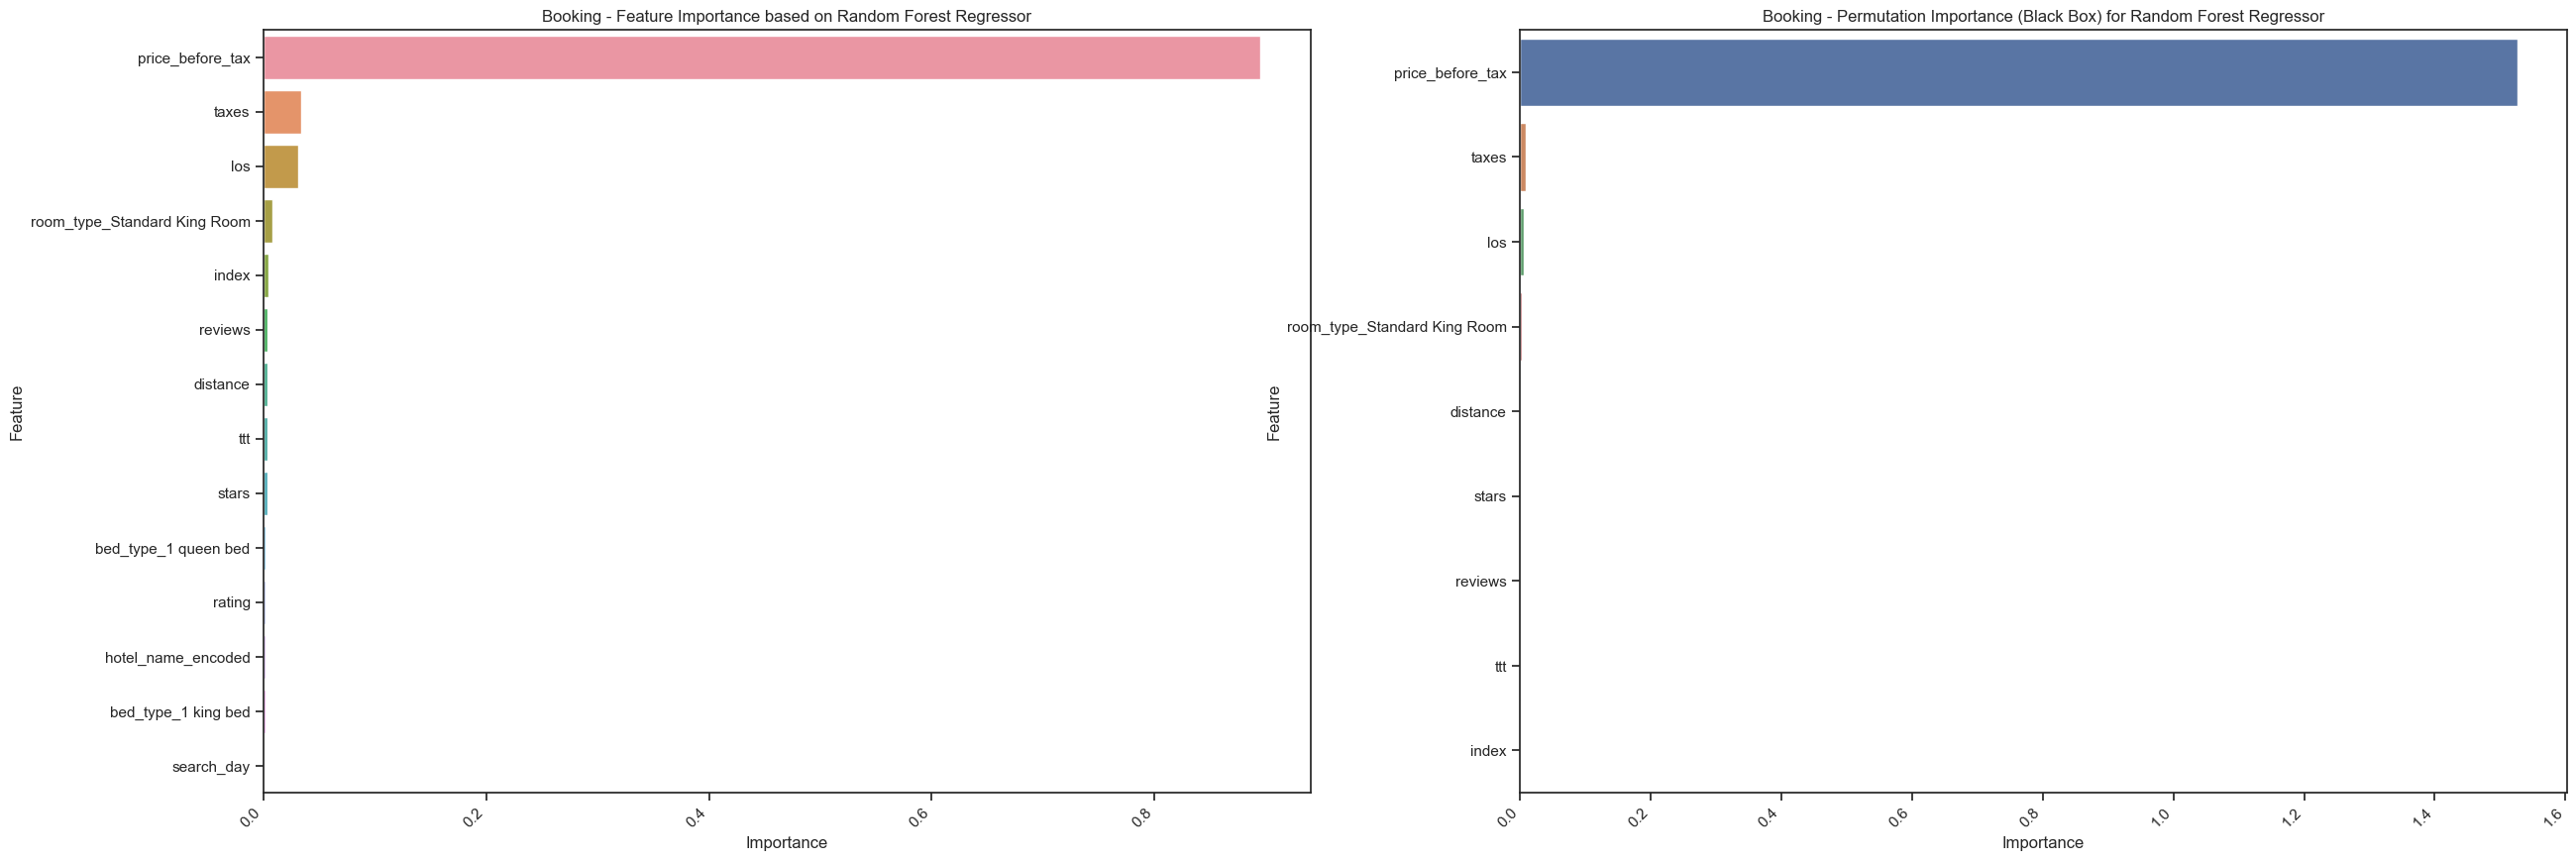

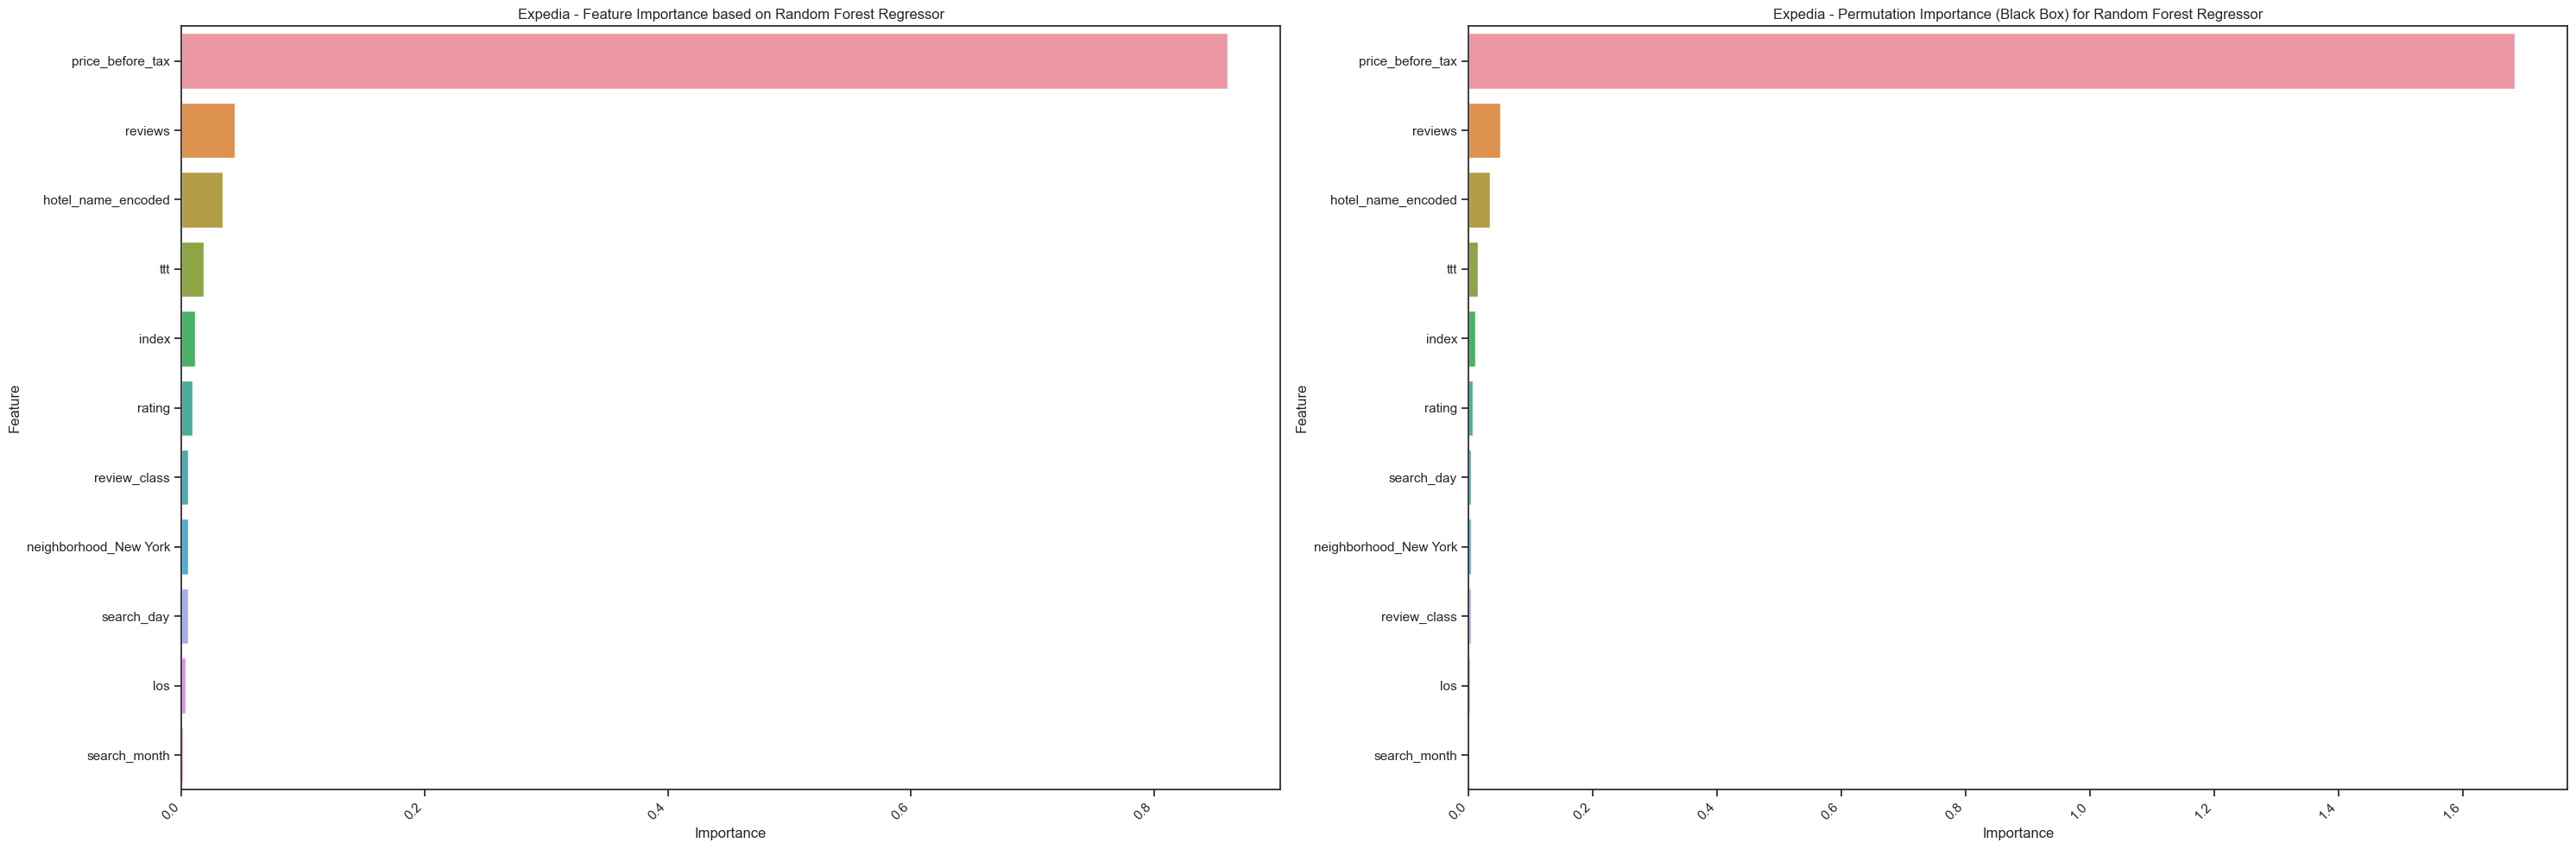

In [32]:
def feature_importance_analysis(model, X_train, y_train, model_name, dataset_name, axes, importance_threshold=0.001):
    # Method 1: Based on the specific algorithm
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
    # Filter features based on importance threshold
    feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > importance_threshold]
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=axes[0])
    axes[0].set_title(f'{dataset_name} - Feature Importance based on {model_name}')
    
    # Method 2: Treat the model as a black box
    perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm_importance.importances_mean})
    # Filter features based on importance threshold
    perm_importance_df = perm_importance_df[perm_importance_df['Importance'] > importance_threshold]
    perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, ax=axes[1])
    axes[1].set_title(f'{dataset_name} - Permutation Importance (Black Box) for {model_name}')

# Adjust figure size and layout
fig, axs_booking = plt.subplots(1, 2, figsize=(30, 10)) # Increased figure size
fig, axs_expedia = plt.subplots(1, 2, figsize=(30, 10)) # Increased figure size

# Apply feature importance analysis for Random Forest Regressor on both datasets
rf_model_booking = RandomForestRegressor().fit(data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'])
feature_importance_analysis(rf_model_booking, data_booking_processed.drop(columns=['price_after_tax']), data_booking_processed['price_after_tax'], "Random Forest Regressor", "Booking", axs_booking)

rf_model_expedia = RandomForestRegressor().fit(data_expedia_processed.drop(columns=['price_after_tax']), data_expedia_processed['price_after_tax'])
feature_importance_analysis(rf_model_expedia, data_expedia_processed.drop(columns=['price_after_tax']), data_expedia_processed['price_after_tax'], "Random Forest Regressor", "Expedia", axs_expedia)

# Improve layout and label rotation for better visibility
for ax in axs_booking:
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right")
for ax in axs_expedia:
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Booking Data (Normalized):


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\U

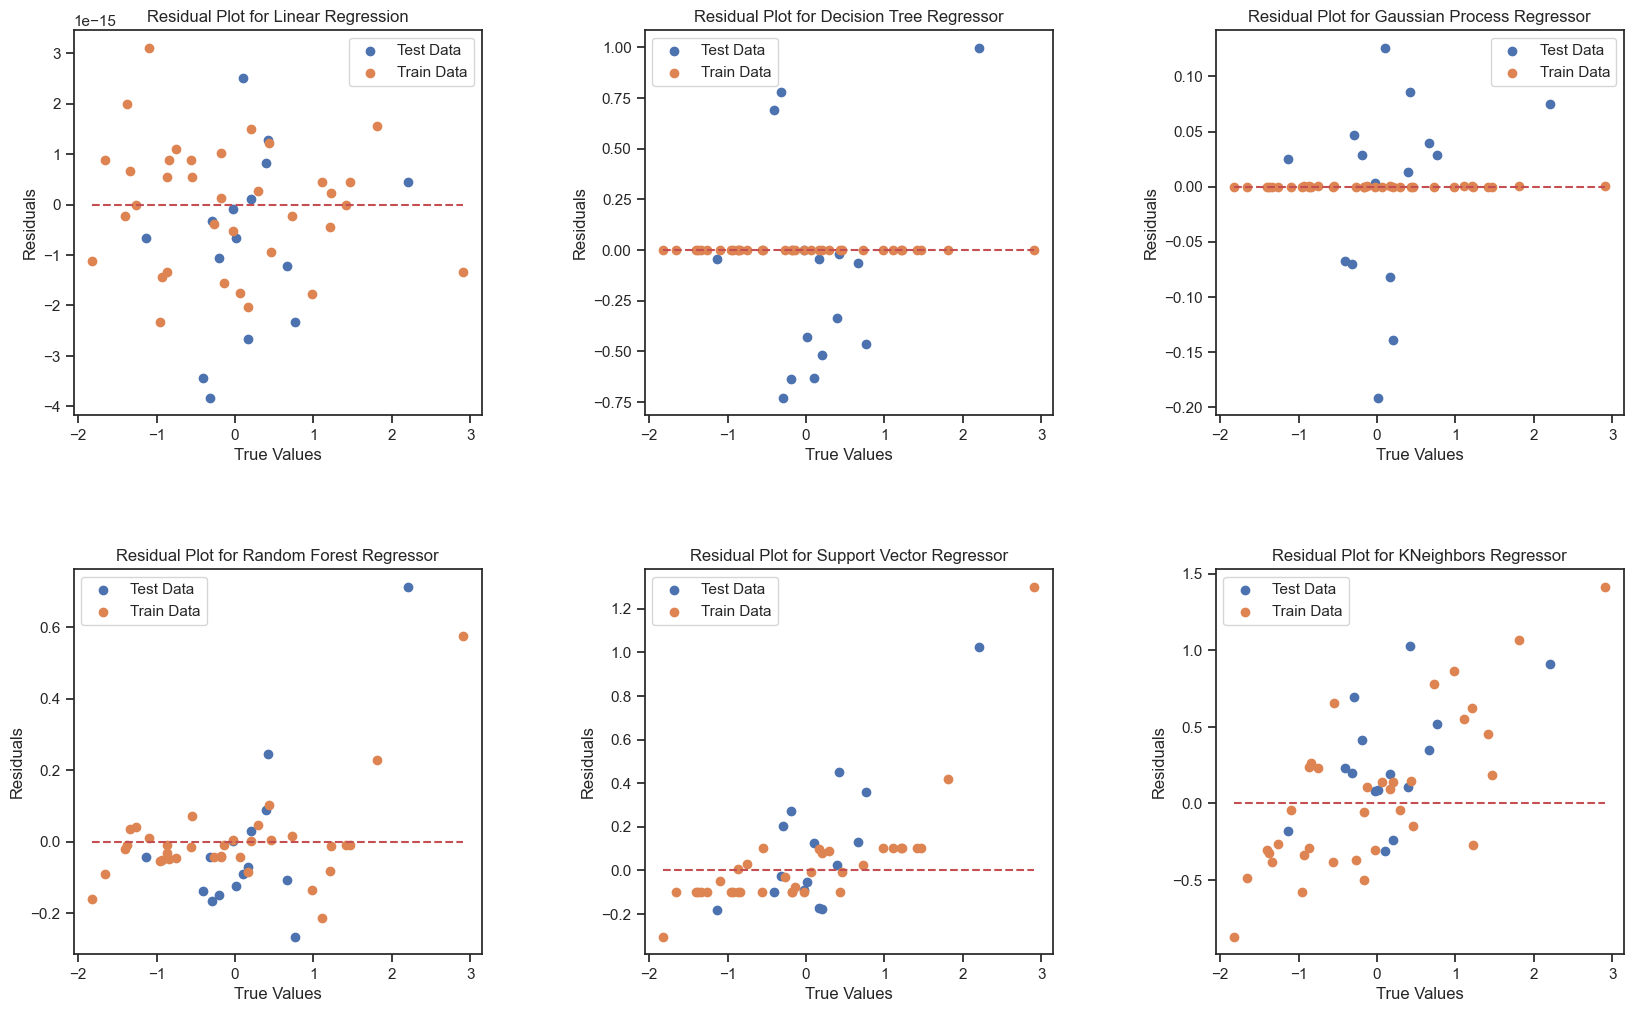

                        Model     MSE Train      MSE Test    RMSE Train  \
0           Linear Regression  1.507557e-30  3.433369e-30  1.227826e-15   
1     Decision Tree Regressor  0.000000e+00  2.799989e-01  0.000000e+00   
2  Gaussian Process Regressor  6.292466e-08  7.147833e-03  2.508479e-04   
3     Random Forest Regressor  1.523601e-02  5.059749e-02  1.234342e-01   
4    Support Vector Regressor  6.302132e-02  1.097738e-01  2.510405e-01   
5        KNeighbors Regressor  2.506733e-01  2.184511e-01  5.006729e-01   

      RMSE Test     MAE Train      MAE Test  R2 Train   R2 Test  
0  1.852935e-15  9.972182e-16  1.430916e-15  1.000000  1.000000  
1  5.291492e-01  0.000000e+00  4.252283e-01  1.000000  0.444470  
2  8.454486e-02  2.045115e-04  6.806050e-02  1.000000  0.985818  
3  2.249389e-01  6.839682e-02  1.514289e-01  0.987248  0.899612  
4  3.313213e-01  1.320811e-01  2.257899e-01  0.947254  0.782204  
5  4.673875e-01  3.970491e-01  3.698753e-01  0.790198  0.566584  

Expedia Dat

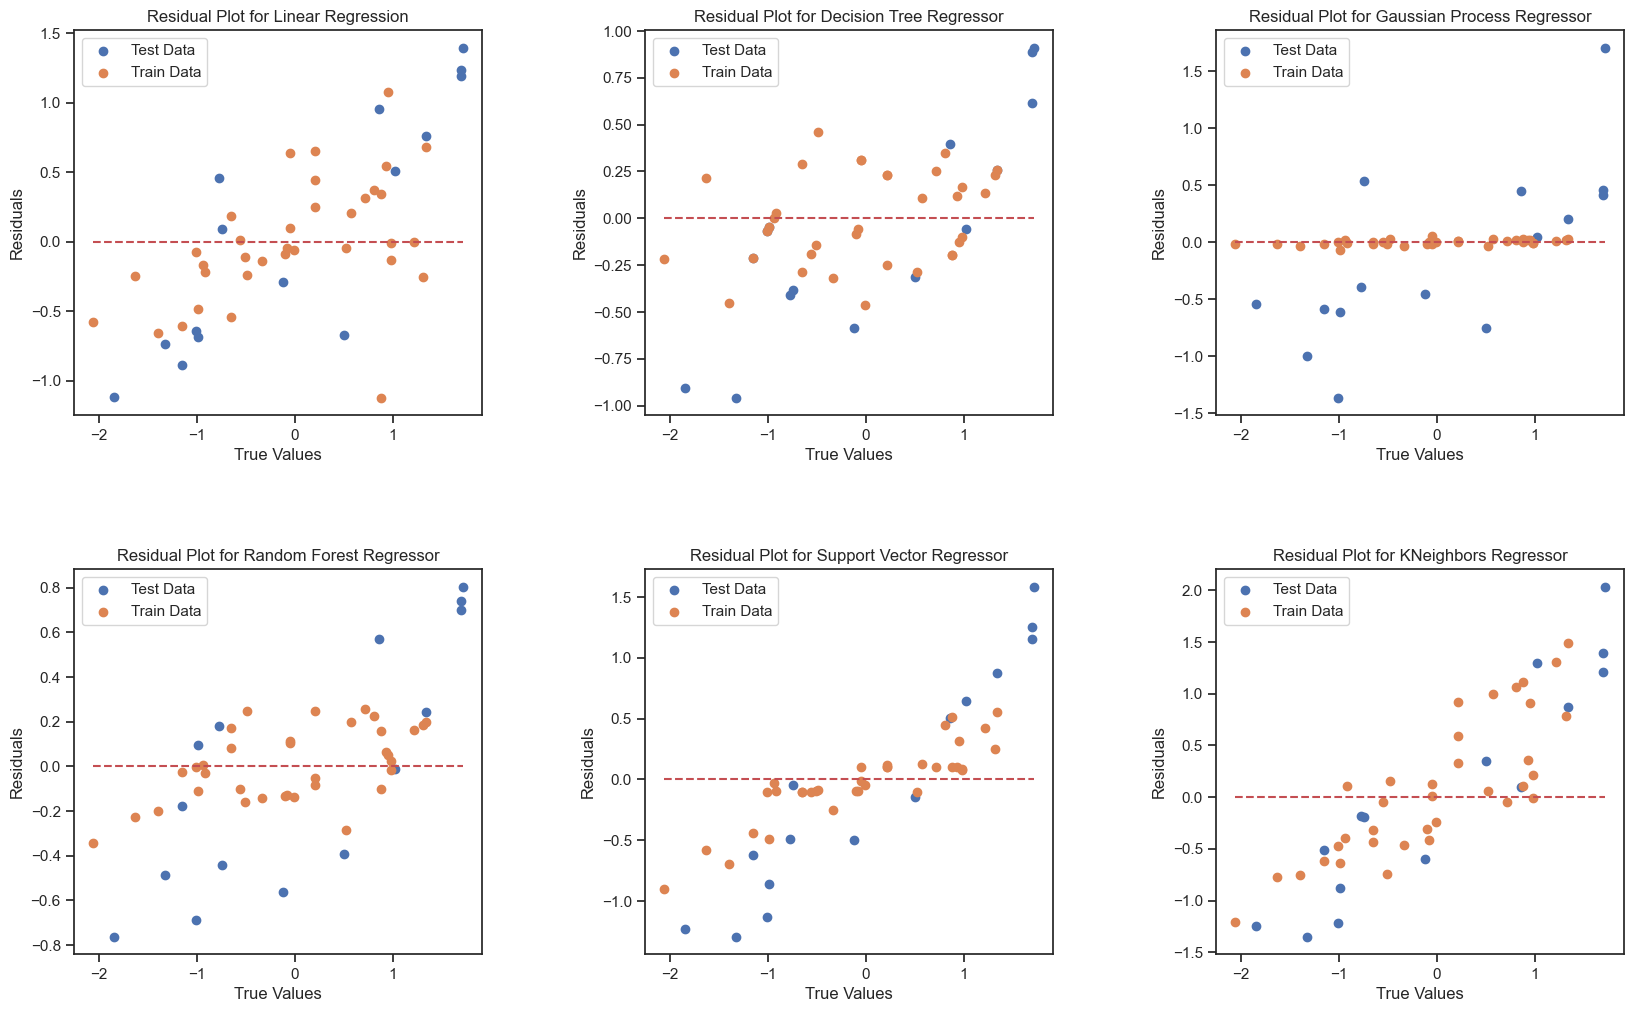

                        Model  MSE Train  MSE Test  RMSE Train  RMSE Test  \
0           Linear Regression   0.192230  0.724704    0.438440   0.851295   
1     Decision Tree Regressor   0.058337  0.317454    0.241530   0.563431   
2  Gaussian Process Regressor   0.000506  0.571382    0.022497   0.755898   
3     Random Forest Regressor   0.025950  0.273906    0.161091   0.523360   
4    Support Vector Regressor   0.098277  0.865036    0.313492   0.930073   
5        KNeighbors Regressor   0.442085  1.098420    0.664895   1.048056   

   MAE Train  MAE Test  R2 Train   R2 Test  
0   0.333103  0.775797  0.757944  0.508871  
1   0.211606  0.466495  0.926542  0.784862  
2   0.017427  0.631873  0.999363  0.612777  
3   0.136658  0.457979  0.967324  0.814375  
4   0.227239  0.822692  0.876249  0.413768  
5   0.529416  0.896546  0.443326  0.255605  


In [33]:
# Normalization Techniques
def normalize_data(data):
    scaler = StandardScaler()
    numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
    data[numeric_features] = scaler.fit_transform(data[numeric_features])
    return data

# Apply normalization and evaluate models
data_booking_normalized = normalize_data(data_booking_processed.copy())
data_expedia_normalized = normalize_data(data_expedia_processed.copy())

print("Booking Data (Normalized):")
results_booking_normalized = train_and_evaluate_models(data_booking_normalized, 'price_after_tax')
print(results_booking_normalized)

print("\nExpedia Data (Normalized):")
results_expedia_normalized = train_and_evaluate_models(data_expedia_normalized, 'price_after_tax')
print(results_expedia_normalized)

Booking Data (Future Split):


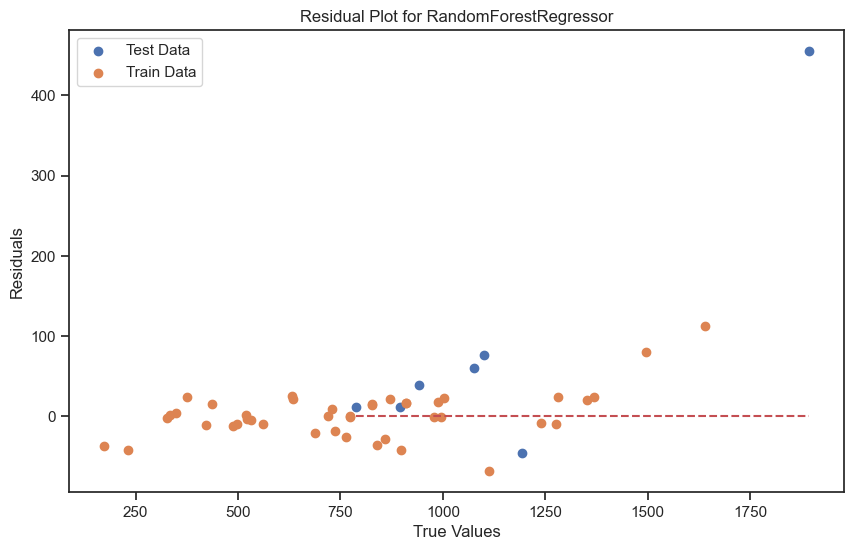

{'Model': 'RandomForestRegressor', 'MSE Train': 900.745160465116, 'MSE Test': 31492.2894, 'RMSE Train': 30.0124167714817, 'RMSE Test': 177.4606700088783, 'MAE Train': 20.499767441860477, 'MAE Test': 99.99142857142859, 'R2 Train': 0.9924415351340101, 'R2 Test': 0.724451718299457}

Expedia Data (Future Split):


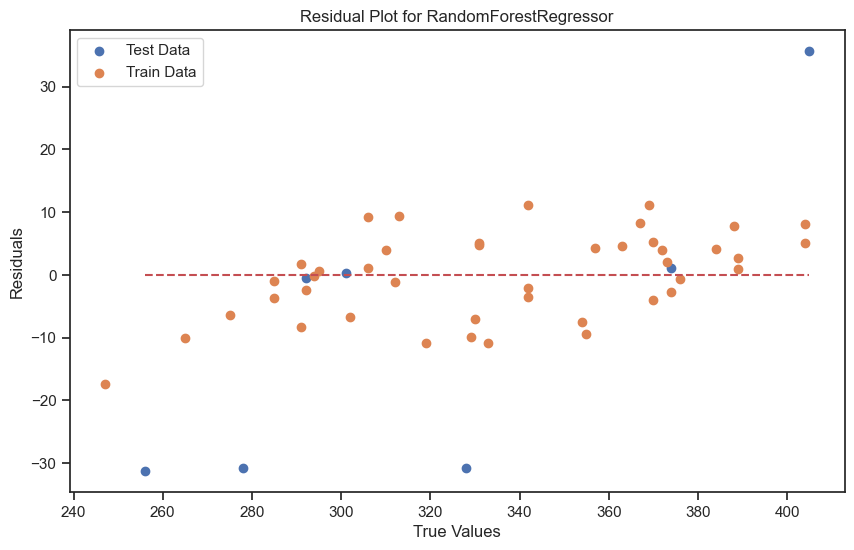

{'Model': 'RandomForestRegressor', 'MSE Train': 45.77236511627908, 'MSE Test': 591.4552571428568, 'RMSE Train': 6.765527704198623, 'RMSE Test': 24.319853148052864, 'MAE Train': 5.602093023255813, 'MAE Test': 18.617142857142856, 'R2 Train': 0.9712177140091781, 'R2 Test': 0.7593594200973148}


In [34]:
# Additional Experiment with Different Train/Test Split
def split_train_test_future(data, target_column, ttt_threshold):
    train_data = data[data['ttt'] <= ttt_threshold]
    test_data = data[data['ttt'] > ttt_threshold]
    
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]
    
    return X_train, X_test, y_train, y_test

def train_and_evaluate_best_model(data, target_column, best_model):
    X_train, X_test, y_train, y_test = split_train_test_future(data, target_column, 25)
    
    best_model.fit(X_train, y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Calculate error metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    results = {
        "Model": best_model.__class__.__name__,
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "RMSE Train": rmse_train,
        "RMSE Test": rmse_test,
        "MAE Train": mae_train,
        "MAE Test": mae_test,
        "R2 Train": r2_train,
        "R2 Test": r2_test
    }
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test - y_pred_test, label="Test Data")
    plt.scatter(y_train, y_train - y_pred_train, label="Train Data")
    plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r', linestyles='dashed')
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {best_model.__class__.__name__}")
    plt.legend()
    plt.show()
    
    return results

# Train and evaluate the best model with different split
best_model = RandomForestRegressor()  # Assuming Random Forest Regressor is the best model
print("Booking Data (Future Split):")
results_booking_future_split = train_and_evaluate_best_model(data_booking_processed, 'price_after_tax', best_model)
print(results_booking_future_split)

print("\nExpedia Data (Future Split):")
results_expedia_future_split = train_and_evaluate_best_model(data_expedia_processed, 'price_after_tax', best_model)
print(results_expedia_future_split)